In [2]:
import numpy as np
import pandas as pd
import random
from collections import OrderedDict
from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

## Reglas de simulación

### Irregular Time Series

#### Sueño

1. Muestreo
	- Se simulan 100 usuarios ficticios con entre 30 y 300 observaciones posibles
	- Duración promedio = 7.5 horas
	- Patrón temporal: Bloques de datos consecutivos (5 a 30 días) con saltos sin registros (2-14 días)

2. Distrbuciones
	- Se asignan las métricas a 1 de 6 posibles fuentes de datos (Source_A … Source_F)
	- La distribución fisiológica está bsada en rangos clínicos para etapas de sueño
		- Proporciones de sueño (light ~50%, REM ~22%, deep ~18%, awake ~6%)
	- Se incluye variabilidad inter/intra-sujeto
		- SD = 0.05 Inter-sujeto
		- SD = 0.03 Variación noche a noche
	- Se introduce ruido gaussiano en las proporciones para capturar diferencias naturales

3. Dependencia temporal
	- Dependencia moderada del día anterior con AR(1) y coeficiente 0.3
	- Mezcla 0.7*props + 0.3*prev_stages que permite asignar persistencia entre noches
		- Ejemplo: si un usuario duerme más REM una noche, la siguiente tendrá ligera influencia en la misma dirección

4. Esquema de anomalías controladas (15%)
	- Pérdida selectiva de una fase (mala detección de REM, problemas con sensores)

#### F.C. 

1. Muestreo
	- 24 horas
	- Múltiples lecturas por día

2. Distribuciones
	- Se simula la frecuencia cardiaca como proceso con componente circadiano + componente nocturno + ruido y eventos
	- FC diurna de 60 a 120 BPM
	- FC nocturna de 10 a 20 BPM
	- Ráfagas de frecuencia cardíaca de 30 a 90 mins para simular eventos de actividad física con probabilidad de 0.3 

3. Dependencia temporal
	- Dependencia con mayor dependencia: AR(1) y coeficiente 0.6

4. Esquema de anomalías controladas
	- Variabilidad intra-día: ±5-15 BPM por factores ambientales
	- Correlación Sueño-FC: Mala calidad de sueño → FC ligeramente elevada


### General

1. Simulación de anomalías de dispositivos
	- Dropout con probabilidad = 0.05 para simular fallos como batería agotada, problemas de conectividad o fallos temporales
2. Multi-dispositivo por usuario
	- Probabilidad de tener múltiples dispocitivos = 0.08
	- Probabilidad de cambiar de dispositivo = 0.02
3. Artefactos por eventos esporádicos (<1% observaciones)



### Fixed and Semi-fixed data (Por simular)

- Fijas:
	- Género
	- Fecha de nacimeinto
	- Estatura
	- Etnia
- Semi-fijas:
	- Peso
	- BMI
	- Ocupación
	- Hipertensión
	- Diabetes
	- Desorden de sueño
	- Enfermedad tiroidea
	- Enfermedad cardiaca
	- Consumo de tabaco
	- Consumo de alcohol
	- Consumo de medicamentos
	- Consumo de suplementos
	- Consumo de cafeina
	- Consumo de azúcar
	- Nivel de actividad física
	- Cantidad de pasos promedio
	- Cronotipo
	- Nivel de estrés

## Población y tamaño

n_users: 100
Variables y distribuciones base

- Edad: Distribución: Normal truncada N(μ=35, σ=10), truncada a [18, 75]
- IMC: Distribución: Normal truncada N(μ=26, σ=4), truncada a [18, 40]
- Género: Categorías: {M: 0.5, F: 0.5}
- Fumador (ancla de dependencias):
    - Bernoulli con p_fumador = 0.23
- Actividad física (baja/media/alta):
    - Base: {baja: 0.3, media: 0.5, alta: 0.2}
    - Condicionada por Fumador para “alta”:
        - p(alta | fumador=si) = 0.12
        - p(alta | fumador=no) = 0.22
    - Redistribución de p(baja), p(media) proporcionalmente al ratio base (0.3:0.5) para completar 1 − p(alta)
- Alcohol (nulo/moderado/alto): Base: {nulo: 0.4, moderado: 0.5, alto: 0.1}
    - Condicionada por Fumador para “alto”:
        - p(alto | fumador=si) = 0.25
        - p(alto | fumador=no) = 0.08
    - Redistribución de p(nulo), p(moderado) proporcional al ratio base (0.4:0.5) para completar 1 − p(alto)
- Suplementación: Categorías: {si: 0.3, no: 0.7}
- Cronotipo: Categorías: {matutino: 0.25, intermedio: 0.5, vespertino: 0.25}
- Hipertensión (HTA): modelo logístico con ajuste por ser fumador

Modelo base: logit(p_hta) = intercept + β_edad*(edad − ref_edad) + β_imc*(imc − ref_imc)
Parámetros: intercept = −4.0; β_edad = 0.05; β_imc = 0.08; ref_edad = 40; ref_imc = 25
p_hta = 1 / (1 + exp(−logit))

Ajuste por fumador:
Multiplicador de odds si fumador: 1.4
odds = p_hta / (1 − p_hta)
odds_ajustada = odds * 1.4 si fumador, en otro caso odds
p_hta_ajustada = odds_ajustada / (1 + odds_ajustada)

Fumador es la variable ancla, afecta:
- Probabilidad de actividad “alta”
- Probabilidad de alcohol “alto”
- Odds de hipertensión (multiplicador 1.4)

Actividad física:
- Se ajusta únicamente en la categoría “alta” según fumador; las categorías “baja” y “media” se reescalan proporcionalmente.

Alcohol:
- Se ajusta únicamente en la categoría “alto” según fumador; “nulo” y “moderado” se reescalan proporcionalmente.

Hipertensión:
- Depende de edad e IMC (modelo logístico) y del estatus de fumador (multiplica odds).

## Definición de parámetros

In [3]:
# Parámetros generales
NUM_USERS = 100
YEAR = 2024

MIN_OBS_DAYS = 30
MAX_OBS_DAYS = 300

DEVICES = ['Source_A', 'Source_B', 'Source_C', 'Source_D', 'Source_E', 'Source_F']

In [ ]:
# Distribuciones basadas en datos poblacionales reales:

REALISTIC_DISTRIBUTIONS = {
    'sleep_apnea': 0.15,          # 15% población
    'hypertension': 0.35,         # 35% adultos
    'diabetes_type2': 0.12,       # 12% población
    'beta_blockers': 0.08,        # 8% población
    'antidepressants': 0.13,      # 13% adultos
    'vitamin_d': 0.45,            # 45% toman suplementos
    'caffeine_high': 0.25,        # 25% alto consumo
    'fitness_sedentary': 0.30,    # 30% sedentarios
    'shift_work': 0.15            # 15% trabajo por turnos
}

In [4]:
POPULATION_DATA = {
    "n_users": 100,
    "edad": {"mu": 35, "sigma": 10, "min": 18, "max": 75},
    "genero": {"M": 0.5, "F": 0.5},
    "p_fumador": 0.23,  # prevalencia base
    "actividad": {"baja": 0.3, "media": 0.5, "alta": 0.2},
    "alcohol": {"nulo": 0.4, "moderado": 0.5, "alto": 0.1},
    "suplementacion": {"si": 0.3, "no": 0.7},
    "imc": {"mu": 26, "sigma": 4, "min": 18, "max": 40},
    "cronotipo": {"matutino": 0.25, "intermedio": 0.5, "vespertino": 0.25},
    # Parámetros para hipertensión en función de edad e IMC (modelo logístico sencillo)
    "hta_logit": {"intercept": -4.0, "beta_edad": 0.05, "beta_imc": 0.08, "ref_edad": 40, "ref_imc": 25},
    # Modificadores condicionales basados en ser fumador (odds/probs tentativas)
    "cond_smoker": {
        "alcohol_alto_if_smoker": 0.25,
        "alcohol_alto_if_nonsmoker": 0.08,
        "actividad_alta_if_smoker": 0.12,
        "actividad_alta_if_nonsmoker": 0.22,
        "hta_odds_multiplier_if_smoker": 1.4
    }
}

In [5]:
rng = np.random.default_rng(42)

In [6]:
def sample_truncated_normal(mu, sigma, low, high, size):
    vals = rng.normal(mu, sigma, size)
    # Re-muestreo simple para truncar
    while True:
        mask_low = vals < low
        mask_high = vals > high
        if not (mask_low.any() or mask_high.any()):
            break
        vals[mask_low] = rng.normal(mu, sigma, mask_low.sum())
        vals[mask_high] = rng.normal(mu, sigma, mask_high.sum())
    return vals

In [7]:
def sample_categorical(probs_dict, size):
    keys = list(probs_dict.keys())
    probs = np.array([probs_dict[k] for k in keys], dtype=float)
    probs = probs / probs.sum()
    idx = rng.choice(len(keys), size=size, p=probs)
    return np.array(keys, dtype=object)[idx]

In [8]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [9]:
def generate_users(config=POPULATION_DATA):
    n = config["n_users"]
    # IDs
    user_id = np.array([f"U{str(i+1).zfill(4)}" for i in range(n)], dtype=object)

    # Edad e IMC (truncados)
    edad = sample_truncated_normal(config["edad"]["mu"], config["edad"]["sigma"],
                                config["edad"]["min"], config["edad"]["max"], n).round().astype(int)
    imc = sample_truncated_normal(config["imc"]["mu"], config["imc"]["sigma"],
                                config["imc"]["min"], config["imc"]["max"], n).round(1)

    # Género
    genero = sample_categorical(config["genero"], n)

    # Fumador (base)
    fumador = rng.random(n) < config["p_fumador"]

    # Actividad física (condicionada a fumador para "alta")
    actividad = np.empty(n, dtype=object)
    base_probs = config["actividad"].copy()
    for i in range(n):
        # Ajustar prob. de "alta" según fumador
        if fumador[i]:
            p_alta = config["cond_smoker"]["actividad_alta_if_smoker"]
        else:
            p_alta = config["cond_smoker"]["actividad_alta_if_nonsmoker"]
        # Redistribuir baja/media manteniendo su proporción relativa
        p_baja_base = config["actividad"]["baja"]
        p_media_base = config["actividad"]["media"]
        sum_bm = p_baja_base + p_media_base
        p_baja = (1 - p_alta) * (p_baja_base / sum_bm)
        p_media = (1 - p_alta) * (p_media_base / sum_bm)
        probs = {"baja": p_baja, "media": p_media, "alta": p_alta}
        actividad[i] = sample_categorical(probs, 1)[0]

    # Alcohol (condicionada a fumador para "alto"; moderado/nulo se ajustan proporcionalmente)
    alcohol = np.empty(n, dtype=object)
    for i in range(n):
        if fumador[i]:
            p_alto = config["cond_smoker"]["alcohol_alto_if_smoker"]
        else:
            p_alto = config["cond_smoker"]["alcohol_alto_if_nonsmoker"]
        # Redistribución nulo/moderado proporcional a la base
        p_nulo_base = config["alcohol"]["nulo"]
        p_mod_base = config["alcohol"]["moderado"]
        sum_nm = p_nulo_base + p_mod_base
        p_nulo = (1 - p_alto) * (p_nulo_base / sum_nm)
        p_mod = (1 - p_alto) * (p_mod_base / sum_nm)
        probs = {"nulo": p_nulo, "moderado": p_mod, "alto": p_alto}
        alcohol[i] = sample_categorical(probs, 1)[0]

    # Suplementación (independiente)
    suplementacion = sample_categorical(config["suplementacion"], n)

    # Cronotipo
    cronotipo = sample_categorical(config["cronotipo"], n)

    # Hipertensión (logística con multiplicador de odds si fumador)
    logit = (config["hta_logit"]["intercept"]
            + config["hta_logit"]["beta_edad"] * (edad - config["hta_logit"]["ref_edad"])
            + config["hta_logit"]["beta_imc"] * (imc - config["hta_logit"]["ref_imc"]))
    p_hta = logistic(logit)
    # Multiplicador de odds por fumador
    odds = p_hta / (1 - p_hta)
    odds *= np.where(fumador, config["cond_smoker"]["hta_odds_multiplier_if_smoker"], 1.0)
    p_hta_adj = odds / (1 + odds)
    hta = rng.random(n) < p_hta_adj

    # Armar DataFrame
    df = pd.DataFrame({
        "user_id": user_id,
        "edad": edad,
        "genero": genero,
        "imc": imc,
        "fumador": np.where(fumador, "si", "no"),
        "actividad": actividad,
        "alcohol": alcohol,
        "suplementacion": suplementacion,
        "cronotipo": cronotipo,
        "hipertension": np.where(hta, "si", "no"),
    })

    return df




In [15]:
df_users = generate_users(POPULATION_DATA)
df_users.head(10)

,user_id,edad,genero,imc,fumador,actividad,alcohol,suplementacion,cronotipo,hipertension
0,U0001,42,M,24.1,no,baja,nulo,si,intermedio,no
1,U0002,49,M,27.9,no,alta,nulo,no,vespertino,no
2,U0003,30,M,22.0,no,media,moderado,no,intermedio,no
3,U0004,40,M,32.0,no,media,nulo,no,intermedio,no
4,U0005,33,F,23.4,no,media,moderado,no,vespertino,no
5,U0006,39,F,28.0,no,alta,moderado,no,intermedio,no
6,U0007,51,F,30.3,no,baja,moderado,no,vespertino,no
7,U0008,40,M,27.5,no,baja,alto,si,intermedio,no
8,U0009,45,F,26.4,si,media,moderado,si,intermedio,no
9,U0010,40,M,26.0,no,media,nulo,si,matutino,no


In [13]:
print("\nDistribuciones:")
for col in ["genero", "fumador", "actividad", "alcohol", "suplementacion", "cronotipo", "hipertension"]:
    print(df_users[col].value_counts(normalize=True).round(3))


Distribuciones:
genero
F    0.52
M    0.48
Name: proportion, dtype: float64
fumador
no    0.7
si    0.3
Name: proportion, dtype: float64
actividad
media    0.50
baja     0.26
alta     0.24
Name: proportion, dtype: float64
alcohol
moderado    0.48
nulo        0.35
alto        0.17
Name: proportion, dtype: float64
suplementacion
no    0.68
si    0.32
Name: proportion, dtype: float64
cronotipo
intermedio    0.46
vespertino    0.32
matutino      0.22
Name: proportion, dtype: float64
hipertension
no    1.0
Name: proportion, dtype: float64


### Parámetros de sueño

In [3]:
# Proporciones promedio de etapas de sueño (baseline poblacional, AASM)
BASE_SLEEP_PROPS = {
    "light": 0.50,
    "rem": 0.22,
    "deep": 0.18,
    "awake": 0.06
}

# Variabilidad individual (inter-sujeto)
SLEEP_INTER_SUBJECT_SD = 0.05   # desvío estándar para personalización de cada usuario

# Ruido intra-noche (intra-sujeto)
SLEEP_NOISE_SD = 0.03           # ruido gaussiano para variación noche a noche

# Persistencia temporal
SLEEP_AR_COEF = 0.3             # cuánto influyen las proporciones de la noche anterior

### Parámetros de frecuencia cardiaca (FC)

In [4]:
# Rango fisiológico de FC promedio nocturna (reposo)
HR_MEAN_BASE = (55, 75)          # bpm, se elige aleatorio por usuario

# Amplitud de variación circadiana
HR_CIRCADIAN_AMP = 3             # bpm

# Diferencias promedio por etapa de sueño (ajuste relativo a HR_base)
HR_STAGE_EFFECTS = {
    "awake": +5,    # suele ser más alta
    "light": 0,     # referencia
    "rem": +2,      # REM tiende a subir y volverse más variable
    "deep": -7      # más baja en deep sleep
}

# Activity event params
ACTIVITY_PROB_DAILY = 0.15         # prob. a user does activity in a given observed day
ACTIVITY_DURATION_MIN = (20, 90)   # minutes
ACTIVITY_INTENSITY_BPM = (30, 90)  # increase above baseline during activity

# Ruido y autocorrelación intra-noche
HR_NOISE_SD = 2.0                # bpm
HR_AR_COEF = 0.6                 # suavidad temporal (AR(1))

# Eventos de microdespertares / arousals
AROUSAL_PROB = 0.1               # prob. de al menos un arousal por noche
AROUSAL_BURST_SD = 5             # subida temporal en bpm durante arousal

# Resolution
RESOLUTION_MINUTES = 1  # resolución de series HR (minutos). Cambia a 1 o más.

### Anomalías

In [5]:
MIN_CONSECUTIVE_DAYS = 5
MAX_CONSECUTIVE_DAYS = 30

# Proporción de noches con anomalías
ANOMALY_RATE_TOTAL_NIGHT = 0.10   # noches sin info de etapas
ANOMALY_RATE_PARTIAL_NIGHT = 0.05 # pérdida selectiva de alguna etapa (ej. REM missing)

# Duración de anomalías continuas
MIN_GAP_DAYS = 2
MAX_GAP_DAYS = 14

# Probabilidad de un dropout largo por usuario
DEVICE_DROPOUT_PROB = 0.05

# Parámetros para cambio de dispositivos
DEVICE_SWITCH_PROB = 0.08        # probabilidad de que un usuario tenga múltiples dispositivos
DEVICE_CHANGE_PROB = 0.02        # probabilidad diaria de cambiar dispositivo (si tiene múltiples)

## Simulación

### Users

In [6]:
def generate_user_timeline(year, min_obs, max_obs,
                           min_block=MIN_CONSECUTIVE_DAYS, max_block=MAX_CONSECUTIVE_DAYS,
                           min_gap=MIN_GAP_DAYS, max_gap=MAX_GAP_DAYS):
    """
    Genera una lista de fechas observadas dentro del año con bloques consecutivos y gaps,
    apuntando entre min_obs y max_obs días observados.
    """
    start = dt.date(year, 1, 1)
    end = dt.date(year, 12, 31)
    total_days = (end - start).days + 1

    target_obs = random.randint(min_obs, max_obs)
    days = []
    cursor = 0

    # Construye bloques hasta alcanzar target obs o terminar el año
    while len(days) < target_obs and cursor < total_days:
        # Block length
        blk = random.randint(min_block, max_block)
        # Ensure we don't go past year
        blk = min(blk, total_days - cursor)
        # Add days of block
        for d in range(blk):
            if len(days) >= target_obs:
                break
            days.append(start + dt.timedelta(days=cursor + d))
        cursor += blk
        # Add gap
        gap = random.randint(min_gap, max_gap)
        cursor += gap
    # Ensure unique & sorted
    days = sorted(list(OrderedDict.fromkeys(days)))
    # Clip to year end
    days = [d for d in days if d <= end]
    return days

### Sleep

In [7]:
def generate_sleep_stages(total_sleep_seconds, prev_stages=None):
    """
    Devuelve dict con duraciones en segundos: {light, rem, deep, awake, fall_asleep}
    total_sleep_seconds: entero
    prev_stages: dict de la noche anterior (segundos). Si None no hay AR(1)
    """
    # Baseline + inter-subject noise
    props = {k: np.random.normal(v, SLEEP_INTER_SUBJECT_SD) for k, v in BASE_SLEEP_PROPS.items()}
    # Normalizar
    vals = np.array(list(props.values()))
    vals = np.clip(vals, 1e-3, None)
    vals = vals / vals.sum()
    props = dict(zip(props.keys(), vals))

    # Dependencia temporal (AR)
    if prev_stages is not None:
        prev_total = sum(prev_stages.get(k, 0) for k in BASE_SLEEP_PROPS.keys())
        if prev_total > 0:
            prev_props = {k: prev_stages.get(k, 0) / prev_total for k in BASE_SLEEP_PROPS.keys()}
            for k in props:
                props[k] = (1 - SLEEP_AR_COEF) * props[k] + SLEEP_AR_COEF * prev_props[k]

    # Ruido intra-noche
    for k in props:
        props[k] = max(1e-3, props[k] + np.random.normal(0, SLEEP_NOISE_SD))

    # Renormalizar
    vals = np.array(list(props.values()))
    vals = vals / vals.sum()
    props = dict(zip(props.keys(), vals))

    # Escalar a segundos
    stages = {k: int(np.round(v * total_sleep_seconds)) for k, v in props.items()}

    # Residuo a fall_asleep/latency
    fall_asleep = int(total_sleep_seconds - sum(stages.values()))
    stages["fall_asleep"] = max(0, fall_asleep)
    return stages

### Heart Rate

In [8]:
def generate_hr_day_profile(date, user_hr_base, minutes_in_day=24*60, resolution_min=RESOLUTION_MINUTES):
    """
    Genera HR de día por minuto (o otra resolución) como combinación de base + circadiana + ruido.
    date: datetime.date para computar fase (si se desea)
    user_hr_base: baseline del usuario (bpm)
    devuelve array length = minutes_in_day / resolution_min
    """
    steps = minutes_in_day // resolution_min
    t = np.arange(steps)
    # Circadian phase: simple cosine, con mínima a 03:00 y máxima por la tarde
    # Convert date->phase seed para variabilidad inter-sujeto/día
    phase_shift = np.random.uniform(-2, 2)  # horas of shift
    # Convert to radians: 24h -> 2pi
    hours = (t * resolution_min) / 60.0
    circ = HR_CIRCADIAN_AMP * np.cos(2 * np.pi * ((hours - 3 + phase_shift) / 24.0))  # min ~ 3am
    # Baseline + circ + noise (AR(1) simple)
    hr = np.zeros(steps)
    prev = user_hr_base
    for i in range(steps):
        noise = np.random.normal(0, HR_NOISE_SD)
        hr_t = user_hr_base + circ[i] + HR_AR_COEF * (prev - user_hr_base) * 0.0 + noise
        hr[i] = hr_t
        prev = hr_t
    return hr

def generate_hr_night_from_stages(stages, user_hr_base, resolution_min=RESOLUTION_MINUTES):
    """
    Genera HR durante el periodo de sueño, en resolución por minuto.
    stages: dict con duraciones en segundos (light,rem,deep,awake,fall_asleep)
    user_hr_base: baseline bpm
    Retorna: vector HR ordenado por minuto (sitúa las etapas concatenadas)
    """
    # Convertimos segundos -> minutes (al redondear)
    hr_list = []
    prev_hr = user_hr_base
    for stage in ["fall_asleep", "deep", "light", "rem", "awake"]:
        dur_sec = stages.get(stage, 0)
        dur_min = int(np.round(dur_sec / 60.0))
        if dur_min <= 0:
            continue
        stage_effect = HR_STAGE_EFFECTS.get(stage, 0)
        # Generar dur_min samples con AR(1)
        for m in range(dur_min):
            hr_t = (user_hr_base
                    + stage_effect
                    + HR_AR_COEF * (prev_hr - user_hr_base)
                    + np.random.normal(0, HR_NOISE_SD))
            hr_list.append(hr_t)
            prev_hr = hr_t
    return np.array(hr_list)


In [9]:
def generate_activity_event(user_hr_base, duration_min=None, intensity_bpm=None):
    """
    Genera una ráfaga de HR por actividad física.
    duration_min: int or None -> random in ACTIVITY_DURATION_MIN
    intensity_bpm: int or None -> random increase in ACTIVITY_INTENSITY_BPM
    """
    if duration_min is None:
        duration_min = random.randint(*ACTIVITY_DURATION_MIN)
    if intensity_bpm is None:
        intensity_bpm = random.randint(*ACTIVITY_INTENSITY_BPM)

    # Modelo simple: subida rápida y decaimiento exponencial al finalizar
    t = np.arange(duration_min)
    # Montée lineal + small jitter
    peak = user_hr_base + intensity_bpm
    # Create ramp up for first 1/4 duration, plateau, then ramp down
    up = max(1, duration_min // 4)
    down = up
    plateau = max(0, duration_min - up - down)
    hr_vals = []
    # Ramp up
    for i in range(up):
        hr_vals.append(user_hr_base + (i + 1) / up * intensity_bpm + np.random.normal(0, 2.0))
    # Plateau
    for i in range(plateau):
        hr_vals.append(peak + np.random.normal(0, 2.0))
    # Ramp down (exponential-ish)
    for i in range(down):
        frac = (down - i) / down
        hr_vals.append(user_hr_base + frac * intensity_bpm + np.random.normal(0, 2.0))
    return np.array(hr_vals)


In [10]:
def apply_night_anomalies(stages, device_name):
    """
    Inserta anomalías:
      - total night missing (con ANOMALY_RATE_TOTAL_NIGHT)
      - partial (e.g., REM missing) with ANOMALY_RATE_PARTIAL_NIGHT
    Retorna (stages_mod, anomaly_label)
    """
    label = None
    r = random.random()
    if r < ANOMALY_RATE_TOTAL_NIGHT:
        # total missing -> mark all stage durations as 0
        new = {k: 0 for k in stages.keys()}
        label = "total_missing"
        return new, label
    r2 = random.random()
    if r2 < ANOMALY_RATE_PARTIAL_NIGHT:
        # choose one stage to drop (except fall_asleep)
        candidate = random.choice(["rem", "deep", "light", "awake"])
        new = stages.copy()
        new[candidate] = 0
        label = f"partial_missing_{candidate}"
        return new, label
    # else no anomaly
    return stages, None

In [11]:
def plot_user_timeline(df_user, user_id):
    """Visualizar timeline y anomalías"""
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Timeline de observaciones
    dates = pd.to_datetime(df_user['date'])
    observed = df_user['observed']
    
    axes[0].scatter(dates[observed], [1]*sum(observed), c='green', alpha=0.6, label='Observed', s=20)
    axes[0].scatter(dates[~observed], [1]*sum(~observed), c='red', alpha=0.8, label='Missing', s=30, marker='x')
    axes[0].set_title(f'User {user_id} Timeline - Observations')
    axes[0].set_ylabel('Status')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dispositivos por fecha
    observed_data = df_user[df_user['observed'] == True]
    if len(observed_data) > 0:
        device_colors = {device: plt.cm.tab10(i) for i, device in enumerate(DEVICES)}
        for device in observed_data['device'].unique():
            device_data = observed_data[observed_data['device'] == device]
            device_dates = pd.to_datetime(device_data['date'])
            axes[1].scatter(device_dates, [device]*len(device_dates), 
                          c=[device_colors[device]], label=device, s=25, alpha=0.7)
    
    axes[1].set_title(f'User {user_id} Device Usage Over Time')
    axes[1].set_ylabel('Device')
    if len(observed_data) > 0:
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)
    
    # HR day patterns (sample)
    sample_days = df_user[df_user['hr_day'].notna()].head(5)
    for i, (_, row) in enumerate(sample_days.iterrows()):
        if row['hr_day'] is not None and len(row['hr_day']) > 0:
            hours = np.arange(len(row['hr_day'])) / 60.0  # convertir minutos a horas
            axes[2].plot(hours, row['hr_day'], alpha=0.7, label=f"{row['date']} ({row['device']})")
    axes[2].set_title('HR Day Profiles (Sample)')
    axes[2].set_ylabel('BPM')
    axes[2].set_xlabel('Hour of Day')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Anomaly distribution
    anomaly_data = df_user[df_user['anomaly'].notna()]
    if len(anomaly_data) > 0:
        anomaly_counts = anomaly_data['anomaly'].value_counts()
        bars = axes[3].bar(range(len(anomaly_counts)), anomaly_counts.values, alpha=0.7)
        axes[3].set_xticks(range(len(anomaly_counts)))
        axes[3].set_xticklabels(anomaly_counts.index, rotation=45, ha='right')
        axes[3].set_title('Anomaly Distribution')
        axes[3].set_ylabel('Count')
        
        # Añadir valores en las barras
        for bar, count in zip(bars, anomaly_counts.values):
            axes[3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        str(count), ha='center', va='bottom')
    else:
        axes[3].text(0.5, 0.5, 'No anomalies detected', ha='center', va='center', 
                    transform=axes[3].transAxes, fontsize=12)
        axes[3].set_title('Anomaly Distribution')
    
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [12]:
def generate_user_data(user_id, year=YEAR):
    """
    Genera los registros para un usuario:
    - timeline de días observados
    - para cada día: sleep summary (stages), hr_day_profile (vector), hr_night (vector), activity events list
    """
    #  baseline user params
    obs_dates = generate_user_timeline(year, MIN_OBS_DAYS, MAX_OBS_DAYS)
    
    # NUEVO: Determinar si el usuario tiene múltiples dispositivos
    has_multiple_devices = random.random() < DEVICE_SWITCH_PROB
    if has_multiple_devices:
        # Usuario con múltiples dispositivos: elegir 2-3 dispositivos
        num_devices = random.choice([2, 3])
        user_devices = random.sample(DEVICES, num_devices)
        primary_device = user_devices[0]  # dispositivo principal
    else:
        # Usuario con un solo dispositivo
        user_devices = [random.choice(DEVICES)]
        primary_device = user_devices[0]
    
    current_device = primary_device
    user_hr_base = random.randint(*HR_MEAN_BASE)

    rows = []
    prev_stages = None

    # possibility of a continuous dropout block for device
    dropout_active = (random.random() < DEVICE_DROPOUT_PROB)
    if dropout_active:
        # choose a dropout period inside the user's date span
        if len(obs_dates) > 5:
            start_idx = random.randint(0, max(0, len(obs_dates) - 3))
            drop_len = random.randint(3, 14)
            dropout_dates = set(obs_dates[start_idx:start_idx + drop_len])
        else:
            dropout_dates = set()
    else:
        dropout_dates = set()

    for d in obs_dates:
        # NUEVO: Cambio de dispositivo (si tiene múltiples)
        if has_multiple_devices and random.random() < DEVICE_CHANGE_PROB:
            # Cambiar a otro dispositivo disponible
            available_devices = [dev for dev in user_devices if dev != current_device]
            if available_devices:
                current_device = random.choice(available_devices)
        
        # if device dropped for that day -> mark as no data (simulate)
        if d in dropout_dates:
            rows.append({
                "user_id": user_id,
                "date": d,
                "device": current_device,
                "observed": False,
                "anomaly": "device_dropout",
                "sleep_stages": None,
                "hr_day": None,
                "hr_night": None,
                "activity_events": []
            })
            continue

        # simulate total sleep time (secs) - sample entre 4 y 9 horas
        total_sleep_h = np.clip(np.random.normal(7, 1.0), 4.0, 9.0)
        total_sleep_seconds = int(round(total_sleep_h * 3600))

        # generate sleep stages (with AR from prev night)
        stages = generate_sleep_stages(total_sleep_seconds, prev_stages)
        # apply anomalies to stages
        stages_mod, anomaly_label = apply_night_anomalies(stages, current_device)

        # generate HR night (from stages_mod)
        hr_night = generate_hr_night_from_stages(stages_mod, user_hr_base)

        # generate HR day profile
        hr_day = generate_hr_day_profile(d, user_hr_base)

        # activity events: randomly decide if activity occurred
        activity_events = []
        if random.random() < ACTIVITY_PROB_DAILY:
            # pick start minute uniformly in waking hours (6:00-21:00)
            start_min = random.randint(6*60, 21*60)
            dur = random.randint(*ACTIVITY_DURATION_MIN)
            activity_hr = generate_activity_event(user_hr_base, duration_min=dur)
            # place into the day vector (modify hr_day copy)
            hr_day_copy = hr_day.copy()
            end_min = min(len(hr_day_copy), start_min + dur)
            # if event overflows end, crop
            n_event = end_min - start_min
            if n_event > 0:
                hr_day_copy[start_min:end_min] = activity_hr[:n_event]
                # store event meta
                activity_events.append({
                    "start_minute": start_min,
                    "duration_min": n_event,
                    "intensity_peak_bpm": float(np.max(activity_hr))
                })
            hr_day = hr_day_copy

        # assemble row
        rows.append({
            "user_id": user_id,
            "date": d,
            "device": current_device,  # MODIFICADO: usar current_device
            "observed": True,
            "anomaly": anomaly_label,
            "sleep_stages": stages_mod,
            "hr_day": hr_day,     # numpy array (per-minute)
            "hr_night": hr_night, # numpy array (per-minute)
            "activity_events": activity_events,
            "user_hr_base": user_hr_base
        })

        prev_stages = stages  # use original stages (not the anomalous) as prev for AR

    df = pd.DataFrame(rows)
    return df

## Datos simulados

In [13]:
# Fijar semilla para reproducibilidad
RANDOM_SEED = 42

In [14]:
def generate_set(num_users=NUM_USERS):
    data = {}
    for u in range(num_users):
        user_id = f"user_{u+1:03d}"
        df_user = generate_user_data(user_id)
        data[user_id] = df_user
    return data

## Data example

In [15]:
synthetic_data = generate_set(NUM_USERS)

In [16]:
synthetic_data['user_006'].head(20)

,user_id,date,device,observed,anomaly,sleep_stages,hr_day,hr_night,activity_events,user_hr_base
0,user_006,2024-01-01,Source_C,True,None,"{'light': 13336, 'rem': 5129, 'deep': 3551, 'a...","[68.26243189329126, 69.53087454541318, 71.0670...","[60.218458298238865, 57.87077295914682, 54.759...",[],66
1,user_006,2024-01-02,Source_C,True,partial_missing_deep,"{'light': 10943, 'rem': 4433, 'deep': 0, 'awak...","[68.0328408083852, 71.64134007380822, 69.53468...","[64.02900849534142, 66.81117401499753, 66.1578...",[],66
2,user_006,2024-01-03,Source_C,True,None,"{'light': 15440, 'rem': 4054, 'deep': 4340, 'a...","[65.95174509091261, 65.91674993746574, 65.3038...","[58.578748206726154, 52.04045741341144, 48.753...","[{'start_minute': 785, 'duration_min': 88, 'in...",66
3,user_006,2024-01-04,Source_C,True,None,"{'light': 15497, 'rem': 4835, 'deep': 3860, 'a...","[65.42958587207478, 70.68071002851362, 65.8953...","[56.52281508360969, 52.15538391692846, 50.4648...","[{'start_minute': 1173, 'duration_min': 62, 'i...",66
4,user_006,2024-01-05,Source_C,True,None,"{'light': 15516, 'rem': 5364, 'deep': 4958, 'a...","[66.25023615733083, 68.13162283397598, 67.5342...","[60.38743953975583, 55.62128111905319, 55.6060...",[],66
5,user_006,2024-01-06,Source_C,True,None,"{'light': 9162, 'rem': 5387, 'deep': 3558, 'aw...","[67.91810464124237, 68.29542055231934, 71.1855...","[57.144142996981415, 58.63891870654886, 55.839...","[{'start_minute': 1065, 'duration_min': 46, 'i...",66
6,user_006,2024-01-07,Source_C,True,total_missing,"{'light': 0, 'rem': 0, 'deep': 0, 'awake': 0, ...","[67.08195500950832, 66.64294678063199, 67.6885...",[],[],66
7,user_006,2024-01-08,Source_C,True,partial_missing_deep,"{'light': 10168, 'rem': 4083, 'deep': 0, 'awak...","[66.95798499714839, 66.243218388578, 69.547807...","[65.403658463798, 65.49951609245052, 62.424008...",[],66
8,user_006,2024-01-09,Source_C,True,None,"{'light': 9641, 'rem': 4800, 'deep': 3302, 'aw...","[65.74624424631878, 70.01165947284075, 72.8766...","[62.38514588460042, 57.02934094979894, 51.6580...",[],66
9,user_006,2024-01-10,Source_C,True,partial_missing_light,"{'light': 0, 'rem': 4271, 'deep': 4835, 'awake...","[70.64130997971539, 69.23578189585751, 71.1384...","[55.06587845026652, 52.018640600272825, 48.160...",[],66


## Time Series

In [51]:
def plot_user_sleep_hr_timeseries(cohort, user_id=None, figsize=(16, 8)):
    """
    Grafica series de tiempo simplificadas de sueño y HR para un usuario específico o aleatorio
    """
    # Seleccionar usuario aleatorio si no se especifica
    if user_id is None:
        user_id = random.choice(list(cohort.keys()))
    
    df_user = cohort[user_id]
    print(f"Graficando series de tiempo para: {user_id}")
    
    # Filtrar solo días observados
    observed_data = df_user[df_user['observed'] == True].copy()
    observed_data['date'] = pd.to_datetime(observed_data['date'])
    observed_data = observed_data.sort_values('date')
    
    if len(observed_data) == 0:
        print("No hay datos observados para este usuario")
        return None
    
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Configurar colores por dispositivo
    devices = observed_data['device'].unique()
    device_colors = {device: plt.cm.Set3(i) for i, device in enumerate(devices)}
    
    # Variables para controlar leyendas
    activity_legend_added = False
    anomaly_legend_added = False
    
    # =================== 1. SERIE DE TIEMPO DE SUEÑO ===================
    
    # Extraer datos de sueño
    sleep_data = []
    for _, row in observed_data.iterrows():
        if row['sleep_stages'] is not None and sum(row['sleep_stages'].values()) > 0:
            stages = row['sleep_stages']
            total_sleep_hours = sum(stages.values()) / 3600
            
            sleep_data.append({
                'date': row['date'],
                'device': row['device'],
                'total_sleep': total_sleep_hours,
                'has_anomaly': row['anomaly'] is not None
            })
    
    if sleep_data:
        sleep_df = pd.DataFrame(sleep_data)
        
        # Graficar duración total de sueño
        for device in devices:
            device_data = sleep_df[sleep_df['device'] == device].sort_values('date')
            if len(device_data) > 0:
                # Separar datos normales y con anomalías
                normal_data = device_data[~device_data['has_anomaly']]
                anomaly_data = device_data[device_data['has_anomaly']]
                
                # Datos normales - crear segmentos continuos
                if len(normal_data) > 0:
                    normal_data = normal_data.sort_values('date')
                    
                    # Identificar gaps > 2 días para crear segmentos
                    date_diffs = normal_data['date'].diff().dt.days
                    gap_indices = normal_data.index[date_diffs > 2].tolist()
                    
                    # Crear segmentos continuos
                    segment_starts = [normal_data.index[0]] + gap_indices
                    
                    for i, segment_start in enumerate(segment_starts):
                        if i == len(segment_starts) - 1:
                            segment_data = normal_data.loc[segment_start:]
                        else:
                            next_start = segment_starts[i + 1]
                            segment_data = normal_data.loc[segment_start:].iloc[:normal_data.index.get_loc(next_start) - normal_data.index.get_loc(segment_start)]
                        
                        if len(segment_data) > 0:
                            axes[0].plot(segment_data['date'], segment_data['total_sleep'], 
                                       'o-', color=device_colors[device], 
                                       label=f'{device}' if i == 0 else "", 
                                       alpha=0.8, markersize=6, linewidth=2)
                
                # Solo cruces para anomalías
                if len(anomaly_data) > 0 and not anomaly_legend_added:
                    axes[0].plot(anomaly_data['date'], anomaly_data['total_sleep'], 
                               'x', color='red', markersize=12, markeredgewidth=3, 
                               alpha=0.9, label='Anomalías')
                    anomaly_legend_added = True
                elif len(anomaly_data) > 0:
                    axes[0].plot(anomaly_data['date'], anomaly_data['total_sleep'], 
                               'x', color='red', markersize=12, markeredgewidth=3, 
                               alpha=0.9)
        
        axes[0].set_title(f'Duración total de Sueño', fontsize=16, fontweight='bold')
        axes[0].set_ylabel('Horas', fontsize=12)
        axes[0].legend(loc='upper right', fontsize=10)
        axes[0].grid(True, alpha=0.3)
        axes[0].set_ylim(0, 10)
    
    # =================== 2. SERIE DE TIEMPO DE HR DIARIA (BANDA DE CONFIANZA) ===================
    
    # Extraer estadísticas diarias de HR con desviación estándar
    hr_data = []
    for _, row in observed_data.iterrows():
        if row['hr_day'] is not None and len(row['hr_day']) > 0:
            hr_array = np.array(row['hr_day'])
            hr_data.append({
                'date': row['date'],
                'device': row['device'],
                'hr_mean': np.mean(hr_array),
                'hr_std': np.std(hr_array),
                'hr_max': np.max(hr_array),
                'hr_min': np.min(hr_array),
                'has_activity': len(row.get('activity_events', [])) > 0,
                'activity_count': len(row.get('activity_events', [])),
                'has_anomaly': row['anomaly'] is not None
            })

    if hr_data:
        hr_df = pd.DataFrame(hr_data)
        
        # Graficar FC con banda de confianza
        for device in devices:
            device_data = hr_df[hr_df['device'] == device].sort_values('date')
            if len(device_data) > 0:
                # Separar datos normales y con anomalías
                normal_data = device_data[~device_data['has_anomaly']]
                anomaly_data = device_data[device_data['has_anomaly']]
                
                # Datos normales - crear segmentos continuos
                if len(normal_data) > 0:
                    normal_data = normal_data.sort_values('date')
                    
                    # Identificar gaps > 2 días para crear segmentos
                    date_diffs = normal_data['date'].diff().dt.days
                    gap_indices = normal_data.index[date_diffs > 2].tolist()
                    segment_starts = [normal_data.index[0]] + gap_indices
                    
                    for i, segment_start in enumerate(segment_starts):
                        if i == len(segment_starts) - 1:
                            segment_data = normal_data.loc[segment_start:]
                        else:
                            next_start = segment_starts[i + 1]
                            segment_data = normal_data.loc[segment_start:].iloc[:normal_data.index.get_loc(next_start) - normal_data.index.get_loc(segment_start)]
                        
                        if len(segment_data) > 0:
                            # Calcular límites de banda de confianza
                            upper_bound = segment_data['hr_mean'] + segment_data['hr_std']
                            lower_bound = segment_data['hr_mean'] - segment_data['hr_std']
                            
                            # Línea principal (promedio)
                            axes[1].plot(segment_data['date'], segment_data['hr_mean'], 
                                       'o-', color=device_colors[device], 
                                       label=f'{device} (Promedio)' if i == 0 else "", 
                                       alpha=0.9, markersize=6, linewidth=2.5, zorder=3)
                            
                            # Banda de confianza (±1 desviación estándar)
                            axes[1].fill_between(segment_data['date'], 
                                               lower_bound, 
                                               upper_bound, 
                                               color=device_colors[device], alpha=0.25,
                                               label=f'{device} (±1σ)' if i == 0 else "",
                                               zorder=1)
                            
                            # Líneas de límites de la banda (opcionales, más sutiles)
                            axes[1].plot(segment_data['date'], upper_bound, 
                                       '--', color=device_colors[device], alpha=0.5, 
                                       linewidth=1, zorder=2)
                            axes[1].plot(segment_data['date'], lower_bound, 
                                       '--', color=device_colors[device], alpha=0.5, 
                                       linewidth=1, zorder=2)
                    
                    # Marcar días con actividad - usar FC máxima con tamaño proporcional
                    activity_days = normal_data[normal_data['has_activity']]
                    if len(activity_days) > 0:
                        # Tamaño proporcional al número de actividades
                        sizes = 80 + activity_days['activity_count'] * 25
                        if not activity_legend_added:
                            axes[1].scatter(activity_days['date'], activity_days['hr_max'], 
                                          color='orange', marker='^', s=sizes, alpha=0.9, 
                                          zorder=5, edgecolors='black', linewidth=1.5,
                                          label='Actividad física')
                            activity_legend_added = True
                        else:
                            axes[1].scatter(activity_days['date'], activity_days['hr_max'], 
                                          color='orange', marker='^', s=sizes, alpha=0.9, 
                                          zorder=5, edgecolors='black', linewidth=1.5)
                
                # Datos con anomalías - cruces en promedio
                if len(anomaly_data) > 0:
                    axes[1].plot(anomaly_data['date'], anomaly_data['hr_mean'], 
                               'x', color='red', markersize=12, markeredgewidth=3, 
                               alpha=0.9, zorder=4)
        
        axes[1].set_title(f'Frecuencia Cardíaca Diaria (Promedio ± Desviación Estándar)', 
                         fontsize=16, fontweight='bold')
        axes[1].set_ylabel('BPM', fontsize=12)
        axes[1].legend(loc='upper right', fontsize=9, ncol=1)
        axes[1].grid(True, alpha=0.3)
    
    # =================== CONFIGURACIÓN GENERAL ===================
    
    # Formatear fechas en todos los ejes
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=10)
        ax.tick_params(axis='y', labelsize=10)
    
    axes[-1].set_xlabel('Fecha (MM/DD)', fontsize=12)
    
    # Título general
    fig.suptitle(f'Series Temporales - {user_id}', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Añadir información del usuario
    total_days = len(observed_data)
    date_range = f"{observed_data['date'].min().strftime('%Y-%m-%d')} a {observed_data['date'].max().strftime('%Y-%m-%d')}"
    devices_text = f"Dispositivos: {', '.join(devices)}"
    
    fig.text(0.02, 0.02, f"{total_days} días observados | {date_range} | {devices_text}", 
             fontsize=11, alpha=0.7)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.12)
    
    # Imprimir estadísticas del usuario
    print(f"ESTADÍSTICAS DEL USUARIO:")
    print(f"  • Días observados: {total_days}")
    print(f"  • Rango temporal: {date_range}")
    print(f"  • Dispositivos utilizados: {len(devices)} ({', '.join(devices)})")
    
    if sleep_data:
        avg_sleep = np.mean([d['total_sleep'] for d in sleep_data])
        print(f"  • Sueño promedio: {avg_sleep:.1f} horas")
    
    if hr_data:
        avg_hr = np.mean([d['hr_mean'] for d in hr_data])
        avg_variability = np.mean([d['hr_std'] for d in hr_data])
        activity_days = sum([d['has_activity'] for d in hr_data])
        print(f"  • HR promedio: {avg_hr:.1f} ± {avg_variability:.1f} BPM")
        print(f"  • Días con actividad: {activity_days} ({activity_days/len(hr_data)*100:.1f}%)")
    
    anomalies = observed_data[observed_data['anomaly'].notna()]
    if len(anomalies) > 0:
        print(f"  • Anomalías detectadas: {len(anomalies)} ({len(anomalies)/total_days*100:.1f}%)")
        anomaly_types = anomalies['anomaly'].value_counts()
        for anomaly_type, count in anomaly_types.items():
            print(f"    - {anomaly_type}: {count}")
    
    return fig, user_id



Graficando series de tiempo para: user_082
ESTADÍSTICAS DEL USUARIO:
  • Días observados: 215
  • Rango temporal: 2024-01-01 a 2024-10-23
  • Dispositivos utilizados: 1 (Source_F)
  • Sueño promedio: 6.9 horas
  • HR promedio: 62.2 ± 3.7 BPM
  • Días con actividad: 26 (12.1%)
  • Anomalías detectadas: 28 (13.0%)
    - total_missing: 19
    - partial_missing_light: 4
    - partial_missing_awake: 2
    - partial_missing_deep: 2
    - partial_missing_rem: 1


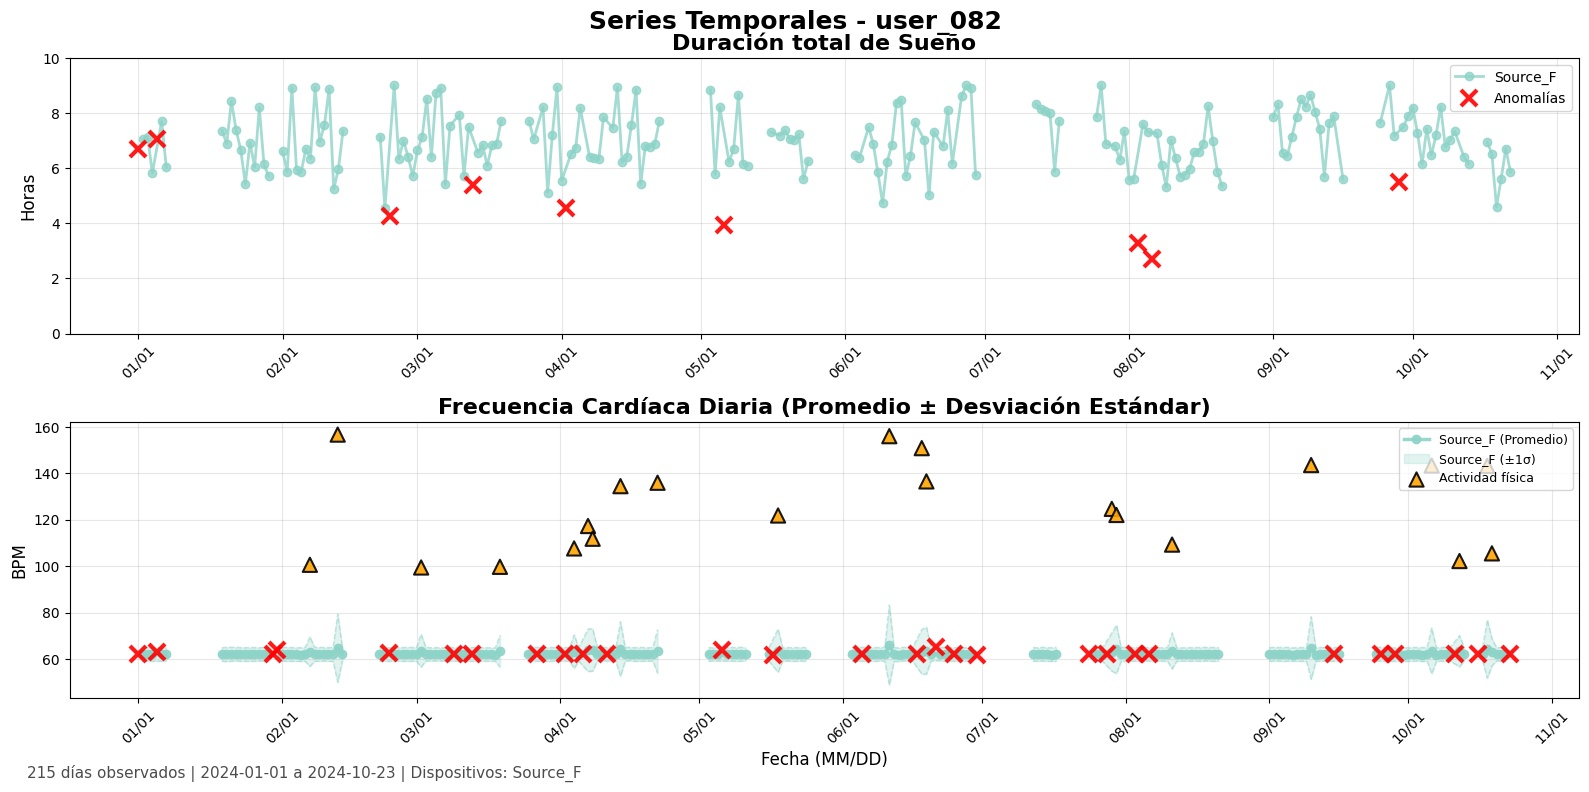

In [79]:
fig1, selected_user = plot_user_sleep_hr_timeseries(synthetic_data)
plt.show()

In [73]:
def plot_multiple_users_comparison(cohort, num_users=3, metric='sleep'):
    """
    Compara series de tiempo de múltiples usuarios aleatorios con manejo de muestreos irregulares
    """
    selected_users = random.sample(list(cohort.keys()), min(num_users, len(cohort)))
    
    fig, axes = plt.subplots(num_users, 1, figsize=(16, 4*num_users))
    if num_users == 1:
        axes = [axes]
    
    colors = plt.cm.tab10(np.linspace(0, 1, num_users))
    
    for i, user_id in enumerate(selected_users):
        df_user = cohort[user_id]
        observed_data = df_user[df_user['observed'] == True].copy()
        observed_data['date'] = pd.to_datetime(observed_data['date'])
        observed_data = observed_data.sort_values('date')
        
        # Variables para controlar leyendas
        anomaly_legend_added = False
        activity_legend_added = False
        
        if metric == 'sleep':
            # =================== SUEÑO CON SEGMENTOS CONTINUOS ===================
            sleep_data = []
            for _, row in observed_data.iterrows():
                if row['sleep_stages'] is not None and sum(row['sleep_stages'].values()) > 0:
                    total_sleep = sum(row['sleep_stages'].values()) / 3600
                    sleep_data.append({
                        'date': row['date'],
                        'device': row['device'],
                        'total_sleep': total_sleep,
                        'has_anomaly': row['anomaly'] is not None
                    })
            
            if sleep_data:
                sleep_df = pd.DataFrame(sleep_data)
                
                # Obtener dispositivos únicos
                devices = sleep_df['device'].unique()
                device_colors = {device: colors[i] if len(devices) == 1 else plt.cm.Set3(j) 
                               for j, device in enumerate(devices)}
                
                # Graficar por dispositivo
                for device in devices:
                    device_data = sleep_df[sleep_df['device'] == device].sort_values('date')
                    if len(device_data) > 0:
                        # Separar datos normales y con anomalías
                        normal_data = device_data[~device_data['has_anomaly']]
                        anomaly_data = device_data[device_data['has_anomaly']]
                        
                        # Datos normales - crear segmentos continuos
                        if len(normal_data) > 0:
                            normal_data = normal_data.sort_values('date')
                            
                            # Identificar gaps > 2 días para crear segmentos
                            date_diffs = normal_data['date'].diff().dt.days
                            gap_indices = normal_data.index[date_diffs > 2].tolist()
                            
                            # Crear segmentos continuos
                            segment_starts = [normal_data.index[0]] + gap_indices
                            
                            for j, segment_start in enumerate(segment_starts):
                                if j == len(segment_starts) - 1:
                                    segment_data = normal_data.loc[segment_start:]
                                else:
                                    next_start = segment_starts[j + 1]
                                    segment_data = normal_data.loc[segment_start:].iloc[:normal_data.index.get_loc(next_start) - normal_data.index.get_loc(segment_start)]
                                
                                if len(segment_data) > 0:
                                    axes[i].plot(segment_data['date'], segment_data['total_sleep'], 
                                               'o-', color=device_colors[device], 
                                               label=f'{device}' if j == 0 and len(devices) > 1 else "", 
                                               alpha=0.8, markersize=4, linewidth=2)
                        
                        # Anomalías - cruces rojas
                        if len(anomaly_data) > 0:
                            if not anomaly_legend_added:
                                axes[i].plot(anomaly_data['date'], anomaly_data['total_sleep'], 
                                           'x', color='red', markersize=8, markeredgewidth=2, 
                                           alpha=0.8, label='Anomalías')
                                anomaly_legend_added = True
                            else:
                                axes[i].plot(anomaly_data['date'], anomaly_data['total_sleep'], 
                                           'x', color='red', markersize=8, markeredgewidth=2, 
                                           alpha=0.8)
                
                # Línea de referencia (7 horas)
                axes[i].axhline(y=7, color='green', linestyle='--', alpha=0.5, 
                              label='7h recomendadas')
                axes[i].set_ylabel('Horas', fontsize=10)
                axes[i].set_title(f'{user_id} - Duración de Sueño', fontsize=12)
                axes[i].set_ylim(0, 10)
        
        elif metric == 'hr':
            # =================== HR CON BANDA DE CONFIANZA Y SEGMENTOS ===================
            hr_data = []
            for _, row in observed_data.iterrows():
                if row['hr_day'] is not None and len(row['hr_day']) > 0:
                    hr_array = np.array(row['hr_day'])
                    hr_data.append({
                        'date': row['date'],
                        'device': row['device'],
                        'hr_mean': np.mean(hr_array),
                        'hr_std': np.std(hr_array),
                        'hr_max': np.max(hr_array),
                        'hr_min': np.min(hr_array),
                        'has_activity': len(row.get('activity_events', [])) > 0,
                        'activity_count': len(row.get('activity_events', [])),
                        'has_anomaly': row['anomaly'] is not None
                    })
            
            if hr_data:
                hr_df = pd.DataFrame(hr_data)
                
                # Obtener dispositivos únicos
                devices = hr_df['device'].unique()
                device_colors = {device: colors[i] if len(devices) == 1 else plt.cm.Set3(j) 
                               for j, device in enumerate(devices)}
                
                # Graficar por dispositivo
                for device in devices:
                    device_data = hr_df[hr_df['device'] == device].sort_values('date')
                    if len(device_data) > 0:
                        # Separar datos normales y con anomalías
                        normal_data = device_data[~device_data['has_anomaly']]
                        anomaly_data = device_data[device_data['has_anomaly']]
                        
                        # Datos normales - crear segmentos continuos con banda
                        if len(normal_data) > 0:
                            normal_data = normal_data.sort_values('date')
                            
                            # Identificar gaps > 2 días para crear segmentos
                            date_diffs = normal_data['date'].diff().dt.days
                            gap_indices = normal_data.index[date_diffs > 2].tolist()
                            segment_starts = [normal_data.index[0]] + gap_indices
                            
                            for j, segment_start in enumerate(segment_starts):
                                if j == len(segment_starts) - 1:
                                    segment_data = normal_data.loc[segment_start:]
                                else:
                                    next_start = segment_starts[j + 1]
                                    segment_data = normal_data.loc[segment_start:].iloc[:normal_data.index.get_loc(next_start) - normal_data.index.get_loc(segment_start)]
                                
                                if len(segment_data) > 0:
                                    # Calcular límites de banda de confianza
                                    upper_bound = segment_data['hr_mean'] + segment_data['hr_std']
                                    lower_bound = segment_data['hr_mean'] - segment_data['hr_std']
                                    
                                    # Línea principal (promedio)
                                    axes[i].plot(segment_data['date'], segment_data['hr_mean'], 
                                               'o-', color=device_colors[device], 
                                               label=f'{device} (Promedio)' if j == 0 and len(devices) > 1 else "", 
                                               alpha=0.8, markersize=4, linewidth=2, zorder=3)
                                    
                                    # Banda de confianza (±1 desviación estándar)
                                    axes[i].fill_between(segment_data['date'], 
                                                       lower_bound, 
                                                       upper_bound, 
                                                       color=device_colors[device], alpha=0.2,
                                                       label=f'{device} (±1σ)' if j == 0 and len(devices) > 1 else "",
                                                       zorder=1)
                            
                            # Marcar días con actividad - usar FC máxima
                            activity_days = normal_data[normal_data['has_activity']]
                            if len(activity_days) > 0:
                                # Tamaño proporcional al número de actividades
                                sizes = 60 + activity_days['activity_count'] * 15
                                if not activity_legend_added:
                                    axes[i].scatter(activity_days['date'], activity_days['hr_max'], 
                                                  color='orange', marker='^', s=sizes, alpha=0.8, 
                                                  zorder=5, edgecolors='black', linewidth=1,
                                                  label='Actividad física')
                                    activity_legend_added = True
                                else:
                                    axes[i].scatter(activity_days['date'], activity_days['hr_max'], 
                                                  color='orange', marker='^', s=sizes, alpha=0.8, 
                                                  zorder=5, edgecolors='black', linewidth=1)
                        
                        # Datos con anomalías - cruces en promedio
                        if len(anomaly_data) > 0:
                            if not anomaly_legend_added:
                                axes[i].plot(anomaly_data['date'], anomaly_data['hr_mean'], 
                                           'x', color='red', markersize=8, markeredgewidth=2, 
                                           alpha=0.8, zorder=4, label='Anomalías')
                                anomaly_legend_added = True
                            else:
                                axes[i].plot(anomaly_data['date'], anomaly_data['hr_mean'], 
                                           'x', color='red', markersize=8, markeredgewidth=2, 
                                           alpha=0.8, zorder=4)
                
                axes[i].set_ylabel('BPM', fontsize=10)
                axes[i].set_title(f'{user_id} - Frecuencia Cardíaca Media (±1σ)', fontsize=12)
        
        # Configuración común
        axes[i].grid(True, alpha=0.3)
        axes[i].xaxis.set_major_formatter(DateFormatter('%m/%d'))
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, fontsize=9)
        
        # Agregar leyenda solo si hay elementos para mostrar
        handles, labels = axes[i].get_legend_handles_labels()
        if handles:
            axes[i].legend(loc='upper right', fontsize=8, ncol=2 if len(handles) > 3 else 1)
    
    axes[-1].set_xlabel('Fecha (MM/DD)', fontsize=11)
    
    # Título general
    metric_name = 'Sueño' if metric == 'sleep' else 'Frecuencia Cardíaca'
    fig.suptitle(f'Comparación de {metric_name} - {len(selected_users)} Usuarios', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    # Imprimir información de los usuarios seleccionados
    print(f"USUARIOS SELECCIONADOS PARA COMPARACIÓN ({metric.upper()}):")
    for user_id in selected_users:
        df_user = cohort[user_id]
        observed_days = len(df_user[df_user['observed'] == True])
        date_range = df_user[df_user['observed'] == True]['date']
        if len(date_range) > 0:
            start_date = pd.to_datetime(date_range).min().strftime('%Y-%m-%d')
            end_date = pd.to_datetime(date_range).max().strftime('%Y-%m-%d')
            devices = df_user[df_user['observed'] == True]['device'].unique()
            print(f"  • {user_id}: {observed_days} días ({start_date} a {end_date}) - {', '.join(devices)}")
    
    return fig, selected_users


USUARIOS SELECCIONADOS PARA COMPARACIÓN (SLEEP):
  • user_006: 269 días (2024-01-01 a 2024-12-31) - Source_C
  • user_021: 205 días (2024-01-01 a 2024-09-25) - Source_C
  • user_066: 85 días (2024-01-01 a 2024-04-25) - Source_E
USUARIOS SELECCIONADOS PARA COMPARACIÓN (HR):
  • user_044: 148 días (2024-01-01 a 2024-07-25) - Source_D
  • user_016: 180 días (2024-01-01 a 2024-10-19) - Source_D, Source_B
  • user_029: 177 días (2024-01-01 a 2024-09-17) - Source_B
  • user_053: 176 días (2024-01-01 a 2024-09-22) - Source_A


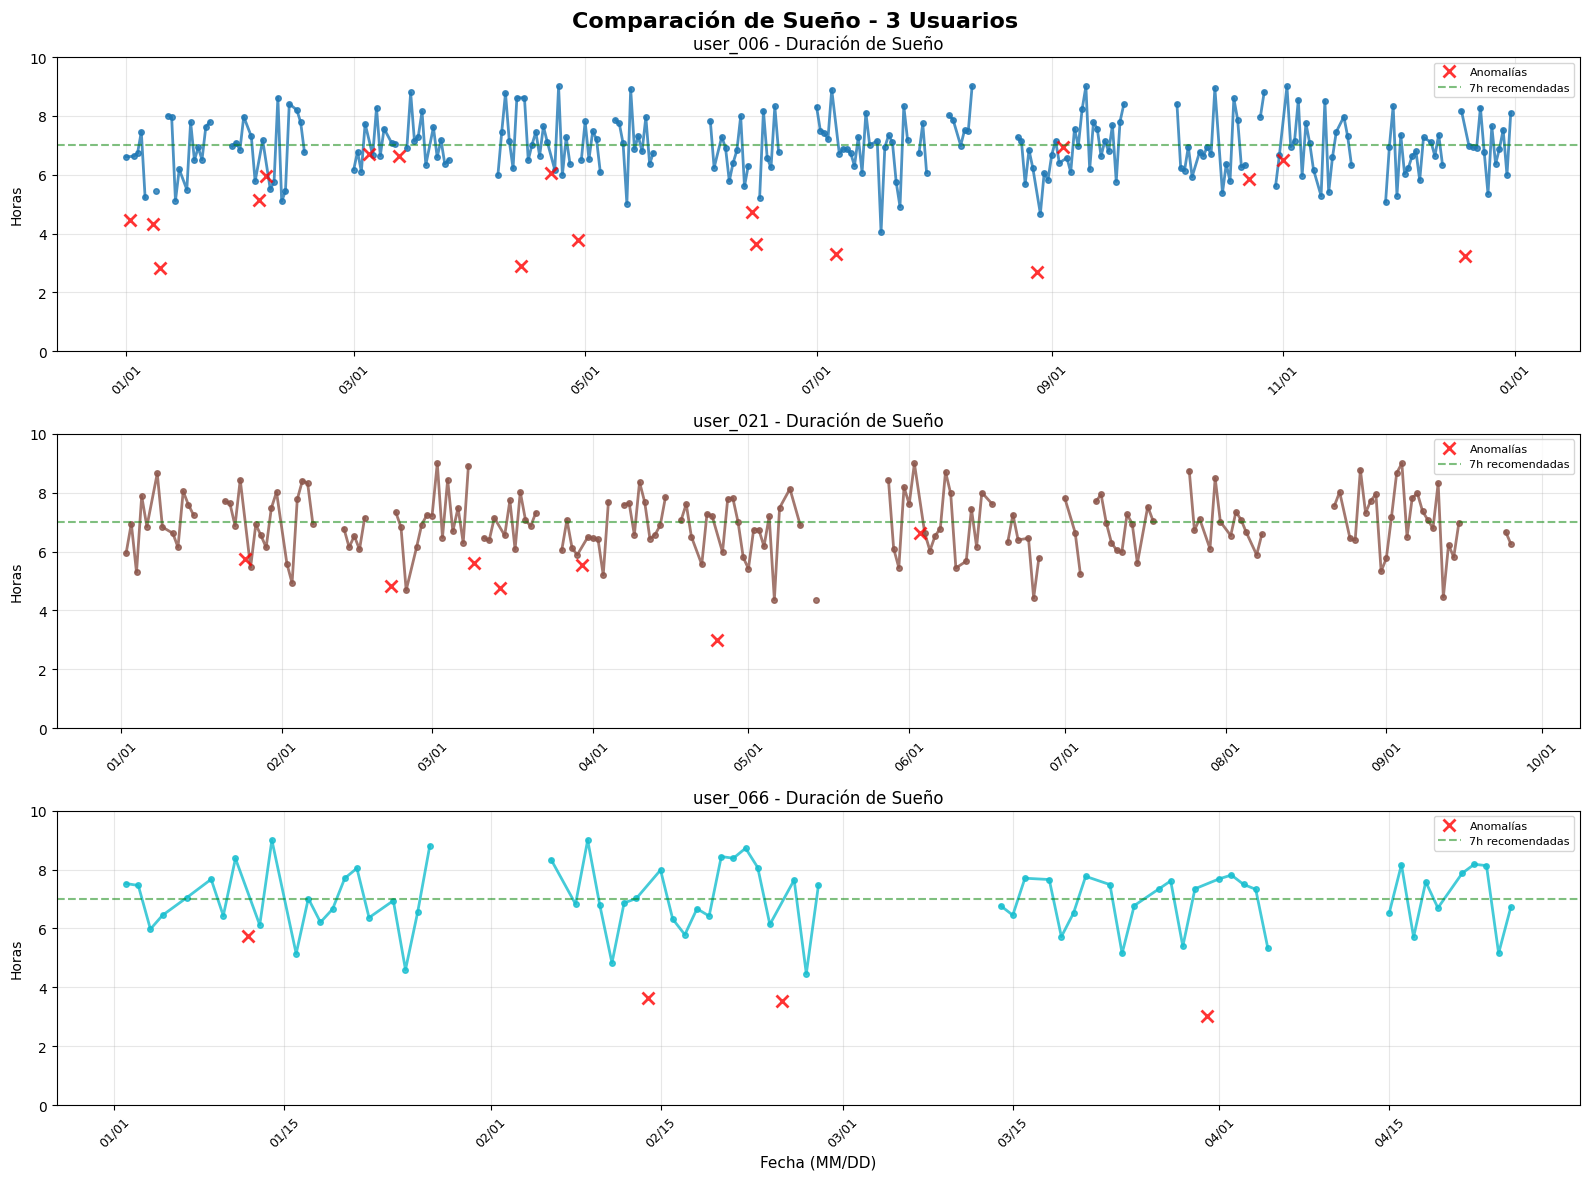

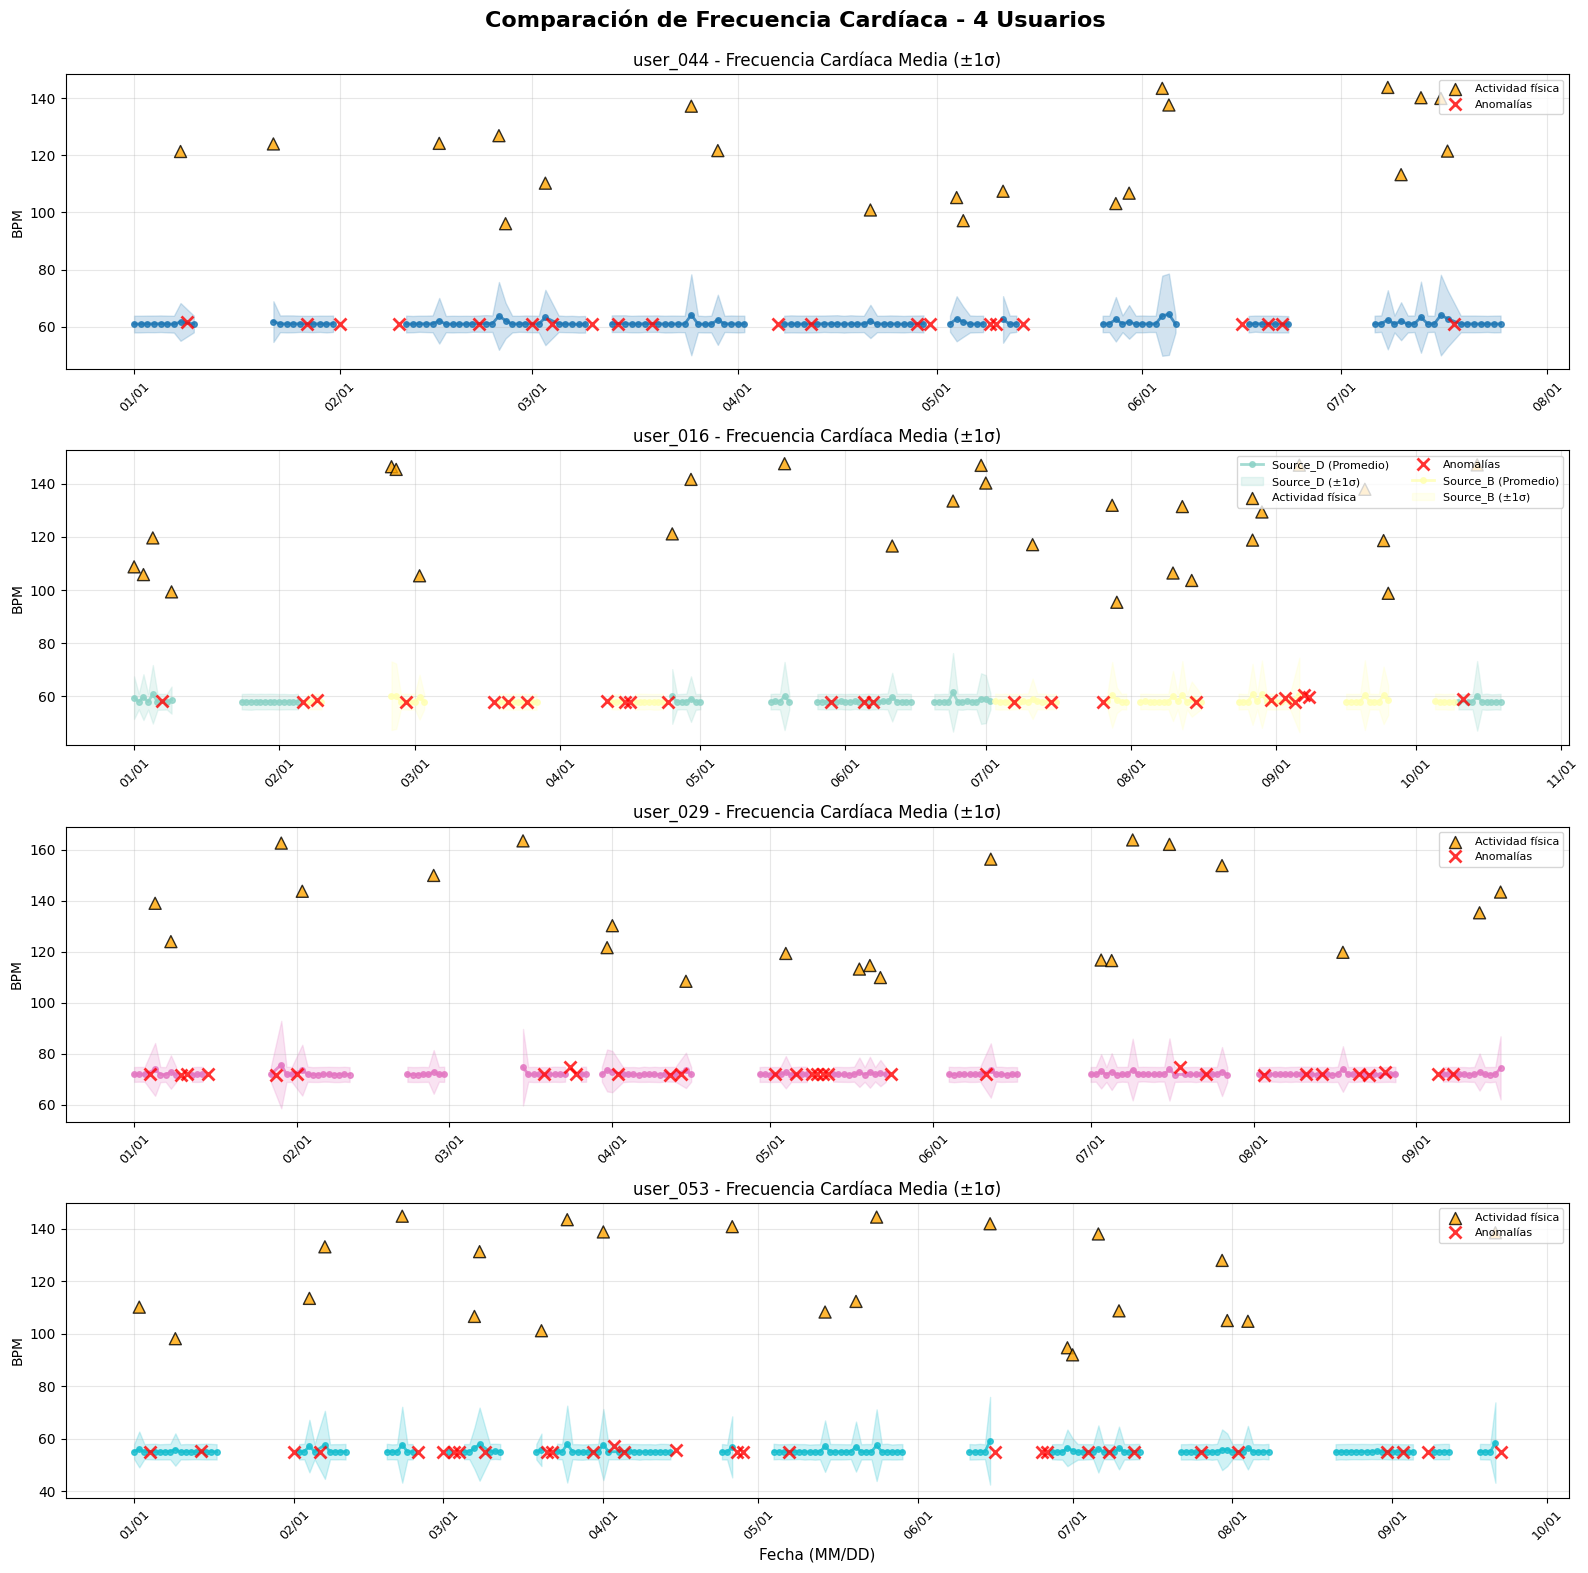

In [74]:
# Comparar sueño de 3 usuarios
fig, users = plot_multiple_users_comparison(synthetic_data, num_users=3, metric='sleep')

# Comparar HR de 4 usuarios  
fig, users = plot_multiple_users_comparison(synthetic_data, num_users=4, metric='hr')

In [60]:
def plot_irregular_timeseries(cohort, user_id, metric='hr_day'):
    """
    Grafica serie temporal irregular mostrando gaps y cambios de dispositivo
    """
    df_user = cohort[user_id]
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Preparar datos temporales
    dates = pd.to_datetime(df_user['date'])
    observed = df_user['observed']
    
    # 1. Timeline con gaps
    axes[0].scatter(dates[observed], [1]*sum(observed), c='green', alpha=0.7, s=30, label='Data Available')
    axes[0].scatter(dates[~observed], [0]*sum(~observed), c='red', alpha=0.8, s=40, marker='x', label='Missing/Dropout')
    
    # Marcar cambios de dispositivo
    device_changes = []
    prev_device = None
    for i, (_, row) in enumerate(df_user.iterrows()):
        if row['observed'] and prev_device is not None and row['device'] != prev_device:
            device_changes.append(row['date'])
        if row['observed']:
            prev_device = row['device']
    
    for change_date in device_changes:
        axes[0].axvline(pd.to_datetime(change_date), color='orange', linestyle='--', alpha=0.7)
    
    axes[0].set_title(f'{user_id} - Data Availability Timeline')
    axes[0].set_ylabel('Data Status')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Serie temporal del métrica elegida con gaps visibles
    observed_data = df_user[df_user['observed'] == True].copy()
    
    if metric == 'hr_day' and len(observed_data) > 0:
        # Extraer estadísticas diarias de HR
        hr_stats = []
        for _, row in observed_data.iterrows():
            if row['hr_day'] is not None and len(row['hr_day']) > 0:
                hr_stats.append({
                    'date': row['date'],
                    'device': row['device'],
                    'hr_mean': np.mean(row['hr_day']),
                    'hr_min': np.min(row['hr_day']),
                    'hr_max': np.max(row['hr_day']),
                    'hr_std': np.std(row['hr_day'])
                })
        
        if hr_stats:
            hr_df = pd.DataFrame(hr_stats)
            hr_df['date'] = pd.to_datetime(hr_df['date'])
            
            # Colorear por dispositivo
            device_colors = {device: plt.cm.tab10(i) for i, device in enumerate(df_user['device'].unique())}
            
            for device in hr_df['device'].unique():
                device_data = hr_df[hr_df['device'] == device]
                axes[1].plot(device_data['date'], device_data['hr_mean'], 
                           'o-', color=device_colors[device], label=f'{device}', alpha=0.8, markersize=4)
                axes[1].fill_between(device_data['date'], 
                                   device_data['hr_min'], device_data['hr_max'], 
                                   color=device_colors[device], alpha=0.2)
    
    elif metric == 'sleep_duration' and len(observed_data) > 0:
        # Duración total de sueño
        sleep_durations = []
        for _, row in observed_data.iterrows():
            if row['sleep_stages'] is not None:
                total_sleep = sum(row['sleep_stages'].values()) / 3600  # convertir a horas
                sleep_durations.append({
                    'date': row['date'],
                    'device': row['device'],
                    'sleep_hours': total_sleep
                })
        
        if sleep_durations:
            sleep_df = pd.DataFrame(sleep_durations)
            sleep_df['date'] = pd.to_datetime(sleep_df['date'])
            
            device_colors = {device: plt.cm.tab10(i) for i, device in enumerate(df_user['device'].unique())}
            
            for device in sleep_df['device'].unique():
                device_data = sleep_df[sleep_df['device'] == device]
                axes[1].plot(device_data['date'], device_data['sleep_hours'], 
                           'o-', color=device_colors[device], label=f'{device}', alpha=0.8, markersize=4)
    
    axes[1].set_title(f'{user_id} - {metric.replace("_", " ").title()} Over Time')
    axes[1].set_ylabel('Value')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Distribución de gaps entre observaciones
    if len(observed_data) > 1:
        observed_dates = pd.to_datetime(observed_data['date']).sort_values()
        gaps = observed_dates.diff().dt.days.dropna()
        
        axes[2].hist(gaps, bins=20, alpha=0.7, edgecolor='black')
        axes[2].axvline(gaps.mean(), color='red', linestyle='--', label=f'Mean gap: {gaps.mean():.1f} days')
        axes[2].set_title('Distribution of Gaps Between Observations')
        axes[2].set_xlabel('Days')
        axes[2].set_ylabel('Frequency')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [61]:
def find_multi_device_users(cohort):
    """
    Encuentra usuarios que utilizaron múltiples dispositivos
    """
    multi_device_users = {}
    
    for user_id, df_user in cohort.items():
        devices_used = df_user[df_user['observed'] == True]['device'].unique()
        if len(devices_used) > 1:
            # Contar observaciones por dispositivo
            device_counts = df_user[df_user['observed'] == True]['device'].value_counts()
            
            # Encontrar transiciones de dispositivo
            transitions = []
            prev_device = None
            for _, row in df_user[df_user['observed'] == True].iterrows():
                if prev_device is not None and row['device'] != prev_device:
                    transitions.append({
                        'date': row['date'],
                        'from': prev_device,
                        'to': row['device']
                    })
                prev_device = row['device']
            
            multi_device_users[user_id] = {
                'devices': list(devices_used),
                'device_counts': device_counts.to_dict(),
                'transitions': transitions,
                'total_transitions': len(transitions)
            }
    
    return multi_device_users

def analyze_user_irregularities(cohort, user_id):
    """
    Análisis detallado de irregularidades para un usuario específico
    """
    df_user = cohort[user_id]
    
    print(f"=== ANÁLISIS DE IRREGULARIDADES - {user_id.upper()} ===\n")
    
    # Estadísticas básicas
    total_days = len(df_user)
    observed_days = sum(df_user['observed'])
    missing_days = total_days - observed_days
    
    print(f"COBERTURA TEMPORAL:")
    print(f"  • Total días en timeline: {total_days}")
    print(f"  • Días observados: {observed_days} ({observed_days/total_days*100:.1f}%)")
    print(f"  • Días faltantes: {missing_days} ({missing_days/total_days*100:.1f}%)")
    
    # Análisis de gaps
    observed_data = df_user[df_user['observed'] == True]
    if len(observed_data) > 1:
        dates = pd.to_datetime(observed_data['date']).sort_values()
        gaps = dates.diff().dt.days.dropna()
        print(f"\n PATRONES DE GAPS:")
        print(f"  • Gap promedio: {gaps.mean():.1f} días")
        print(f"  • Gap máximo: {gaps.max()} días")
        print(f"  • Gap mínimo: {gaps.min()} días")
        print(f"  • Número de gaps > 7 días: {sum(gaps > 7)}")
    
    # Dispositivos utilizados
    devices_used = df_user[df_user['observed'] == True]['device'].unique()
    print(f"\n📱 DISPOSITIVOS:")
    print(f"  • Dispositivos únicos: {len(devices_used)}")
    print(f"  • Lista: {list(devices_used)}")
    
    if len(devices_used) > 1:
        device_counts = df_user[df_user['observed'] == True]['device'].value_counts()
        print(f"  • Distribución por dispositivo:")
        for device, count in device_counts.items():
            print(f"    - {device}: {count} días ({count/observed_days*100:.1f}%)")
    
    # Anomalías
    anomalies = df_user[df_user['anomaly'].notna()]
    if len(anomalies) > 0:
        print(f"\n⚠️  ANOMALÍAS DETECTADAS:")
        anomaly_counts = anomalies['anomaly'].value_counts()
        for anomaly, count in anomaly_counts.items():
            print(f"  • {anomaly}: {count} ocurrencias")
    else:
        print(f"\nSin anomalías detectadas")
    
    return {
        'total_days': total_days,
        'observed_days': observed_days,
        'coverage_rate': observed_days/total_days,
        'devices_used': list(devices_used),
        'anomaly_counts': anomalies['anomaly'].value_counts().to_dict() if len(anomalies) > 0 else {}
    }

Usuarios con múltiples dispositivos: 9

Ejemplo - user_006:
  Dispositivos: ['Source_E', 'Source_D']
  Transiciones: 1


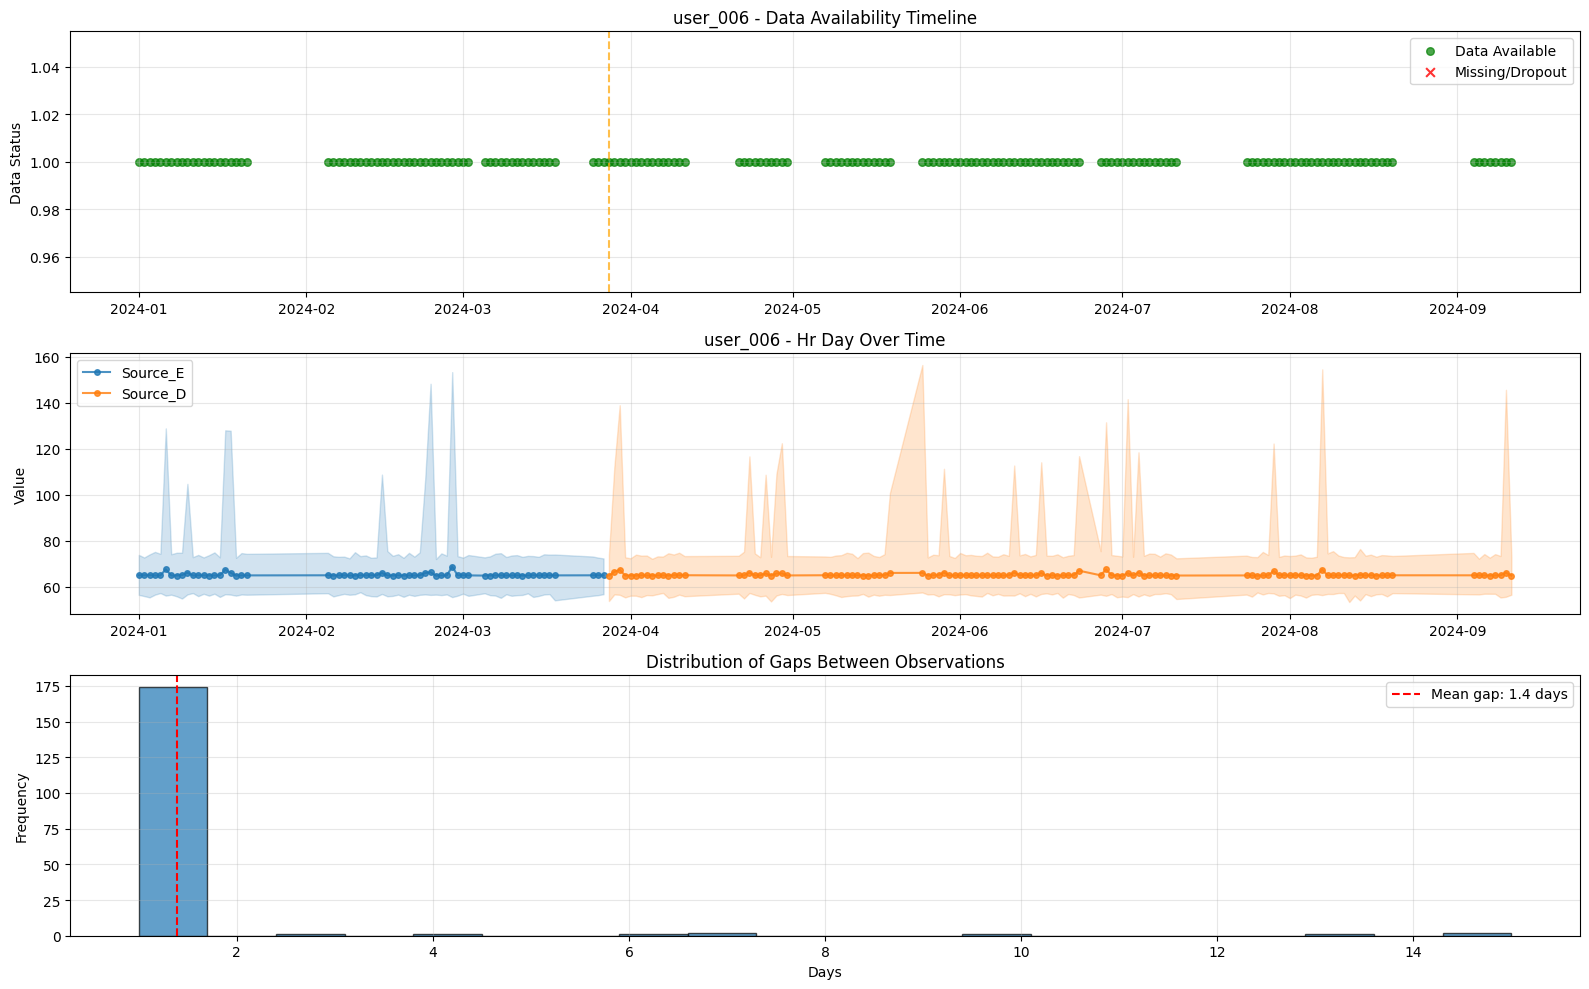

=== ANÁLISIS DE IRREGULARIDADES - USER_006 ===

COBERTURA TEMPORAL:
  • Total días en timeline: 184
  • Días observados: 184 (100.0%)
  • Días faltantes: 0 (0.0%)

 PATRONES DE GAPS:
  • Gap promedio: 1.4 días
  • Gap máximo: 15.0 días
  • Gap mínimo: 1.0 días
  • Número de gaps > 7 días: 4

📱 DISPOSITIVOS:
  • Dispositivos únicos: 2
  • Lista: ['Source_E', 'Source_D']
  • Distribución por dispositivo:
    - Source_D: 119 días (64.7%)
    - Source_E: 65 días (35.3%)

⚠️  ANOMALÍAS DETECTADAS:
  • total_missing: 15 ocurrencias
  • partial_missing_deep: 3 ocurrencias
  • partial_missing_rem: 2 ocurrencias
  • partial_missing_awake: 2 ocurrencias
  • partial_missing_light: 1 ocurrencias


In [69]:
# Encontrar usuarios con múltiples dispositivos
multi_device_users = find_multi_device_users(synthetic_data)
print(f"Usuarios con múltiples dispositivos: {len(multi_device_users)}")

if multi_device_users:
    # Mostrar el primer usuario con múltiples dispositivos
    first_multi_user = list(multi_device_users.keys())[0]
    print(f"\nEjemplo - {first_multi_user}:")
    user_info = multi_device_users[first_multi_user]
    print(f"  Dispositivos: {user_info['devices']}")
    print(f"  Transiciones: {user_info['total_transitions']}")
    
    # Graficar serie temporal irregular
    fig = plot_irregular_timeseries(synthetic_data, first_multi_user, metric='hr_day')
    plt.show()
    
    # Análisis detallado
    stats = analyze_user_irregularities(synthetic_data, first_multi_user)

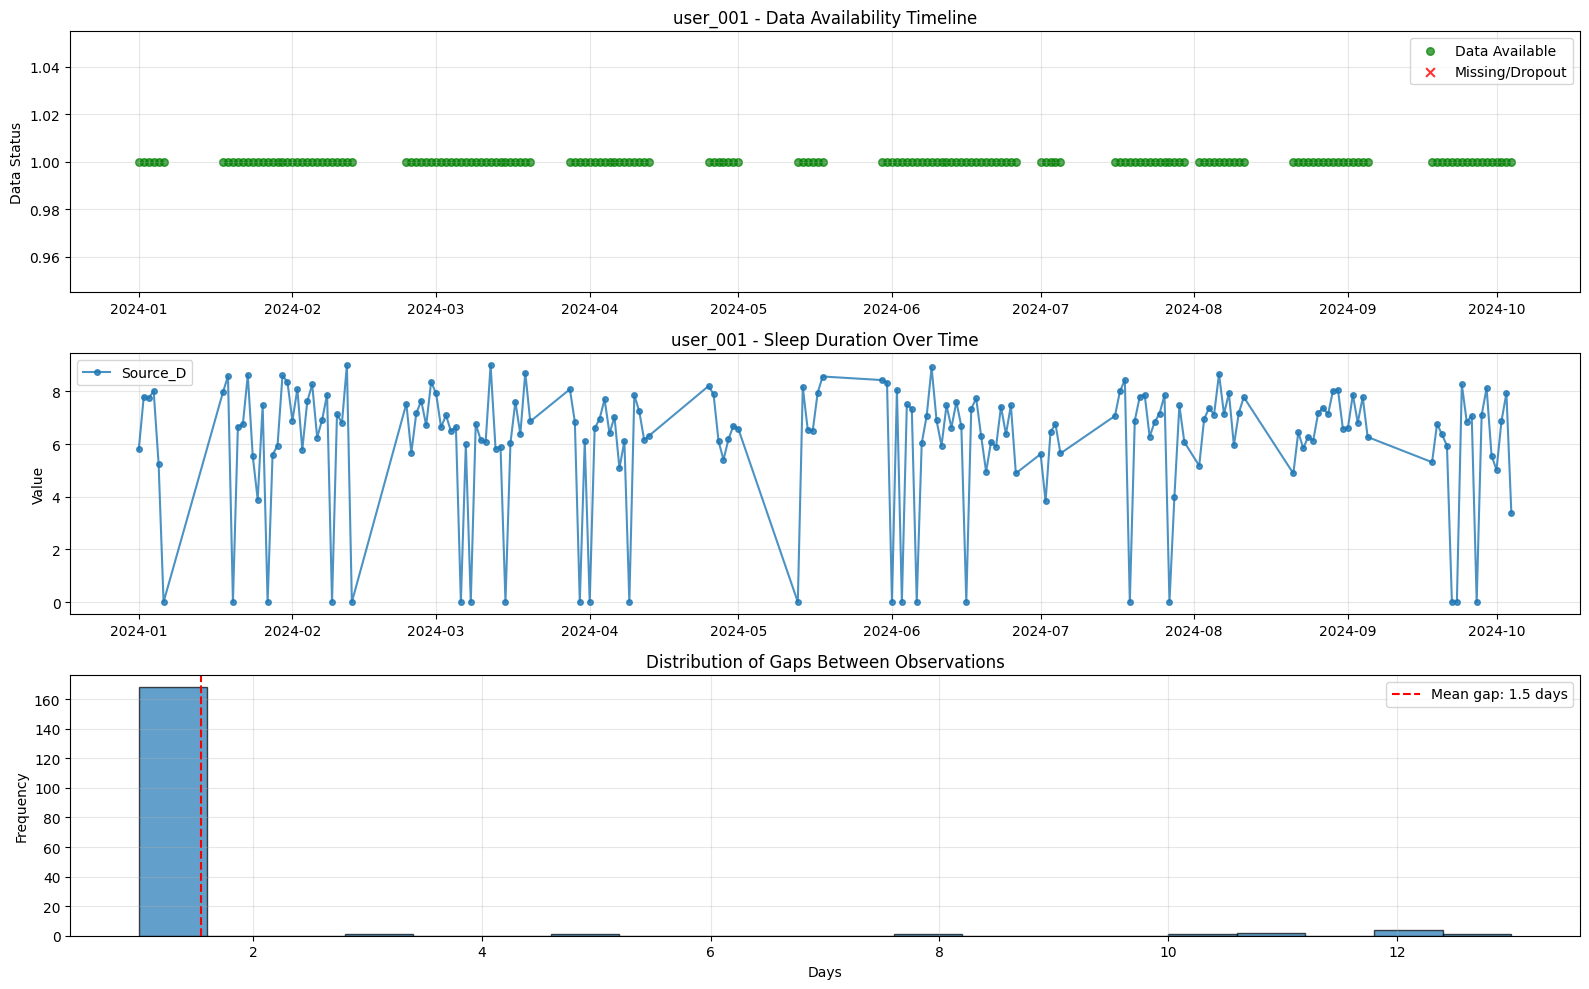

=== ANÁLISIS DE IRREGULARIDADES - USER_001 ===

COBERTURA TEMPORAL:
  • Total días en timeline: 180
  • Días observados: 180 (100.0%)
  • Días faltantes: 0 (0.0%)

 PATRONES DE GAPS:
  • Gap promedio: 1.5 días
  • Gap máximo: 13.0 días
  • Gap mínimo: 1.0 días
  • Número de gaps > 7 días: 9

📱 DISPOSITIVOS:
  • Dispositivos únicos: 1
  • Lista: ['Source_D']

⚠️  ANOMALÍAS DETECTADAS:
  • total_missing: 21 ocurrencias
  • partial_missing_deep: 4 ocurrencias
  • partial_missing_light: 3 ocurrencias
  • partial_missing_awake: 2 ocurrencias
  • partial_missing_rem: 2 ocurrencias


In [65]:
# Analizar cualquier usuario específico
example_user = "user_001"
fig = plot_irregular_timeseries(synthetic_data, example_user, metric='sleep_duration')
plt.show()

stats = analyze_user_irregularities(synthetic_data, example_user)

## Metadatos

In [64]:
synthetic_data

{'user_001':       user_id        date    device  observed                anomaly  \
 0    user_001  2024-01-01  Source_D      True                   None   
 1    user_001  2024-01-02  Source_D      True                   None   
 2    user_001  2024-01-03  Source_D      True                   None   
 3    user_001  2024-01-04  Source_D      True                   None   
 4    user_001  2024-01-05  Source_D      True                   None   
 ..        ...         ...       ...       ...                    ...   
 175  user_001  2024-09-30  Source_D      True                   None   
 176  user_001  2024-10-01  Source_D      True                   None   
 177  user_001  2024-10-02  Source_D      True   partial_missing_deep   
 178  user_001  2024-10-03  Source_D      True                   None   
 179  user_001  2024-10-04  Source_D      True  partial_missing_light   
 
                                           sleep_stages  \
 0    {'light': 10754, 'rem': 5131, 'deep': 3075, '

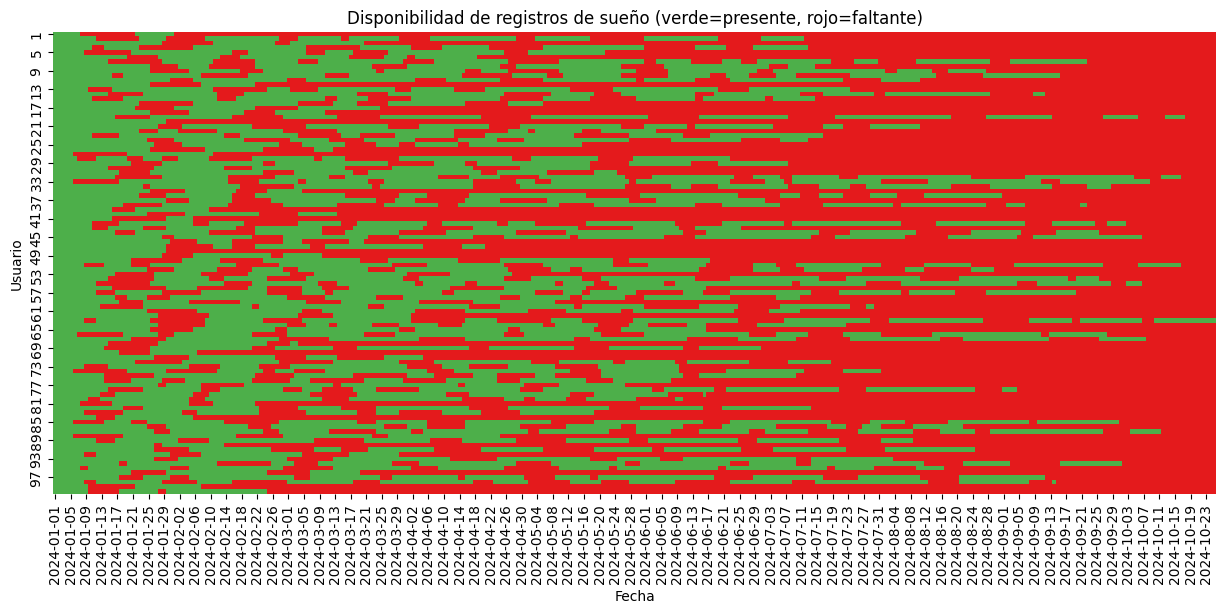

In [35]:
matrix = df.pivot(index="user_id", columns="date", values="total_sleep").notna()

plt.figure(figsize=(15,6))
sns.heatmap(matrix, cmap=["#e41a1c","#4daf4a"], cbar=False)
plt.title("Disponibilidad de registros de sueño (verde=presente, rojo=faltante)")
plt.xlabel("Fecha")
plt.ylabel("Usuario")
plt.show()